# Pre-processing

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
new_col = pd.read_csv('data/gender_submission.csv')['Survived']
df_test.insert(0, 'Survived', new_col)

df = pd.concat([df_train, df_test], ignore_index=True)

In [4]:
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']

In [5]:
df = df.drop(columns_to_drop, axis=1)

df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
df = pd.get_dummies(df, columns=['Sex'])

df

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,0,3,22.000000,1,0,7.2500,0,1
1,1,1,38.000000,1,0,71.2833,1,0
2,1,3,26.000000,0,0,7.9250,1,0
3,1,1,35.000000,1,0,53.1000,1,0
4,0,3,35.000000,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...
1304,0,3,29.881138,0,0,8.0500,0,1
1305,1,1,39.000000,0,0,108.9000,1,0
1306,0,3,38.500000,0,0,7.2500,0,1
1307,0,3,29.881138,0,0,8.0500,0,1


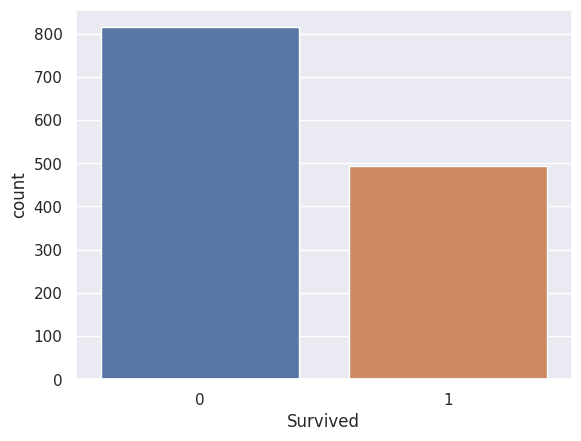

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.countplot(x='Survived', data=df)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(['Survived'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Modeling

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN

pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardize features by removing the mean and scaling to unit variance
    ('pca', PCA(n_components=4, random_state=1)), # Dimensionality reduction using Principal Component Analysis
    ('knn', KNN()),
])

In [9]:
# Model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=1)

params = {
    'knn__n_neighbors': range(1, 15),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

grid = GridSearchCV(pipeline, params, cv=kf)
grid.fit(X_train, y_train)
pipeline = grid.best_estimator_

In [10]:
print(grid.best_params_)
print(grid.best_score_)

{'knn__metric': 'manhattan', 'knn__n_neighbors': 14, 'knn__weights': 'uniform'}
0.8746547103689961


In [11]:
y_pred = pipeline.predict(X_test)

# Model Evaluation

Accuracy: 83.84%
Negative in all cases: 57.93%

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       190
           1       0.86      0.74      0.79       138

    accuracy                           0.84       328
   macro avg       0.84      0.82      0.83       328
weighted avg       0.84      0.84      0.84       328



<Axes: >

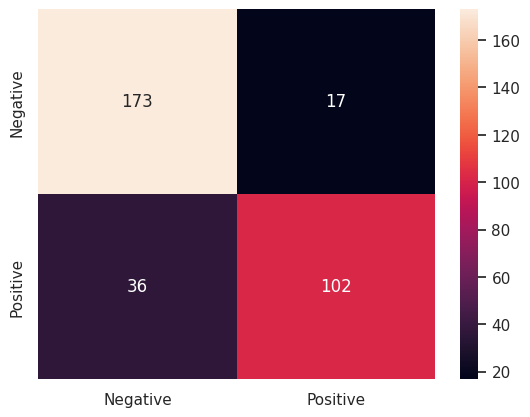

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)*100
negative_in_all = accuracy_score(y_test, [0]*len(y_test))*100

print(f'Accuracy: {accuracy:.2f}%')
print(f'Negative in all cases: {negative_in_all:.2f}%\n')

print(classification_report(y_test, y_pred))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
sns.heatmap(df_cm, annot=True, fmt='.0f')